Aplicar los conocimientos de programación orientada a objetos y machine learning para implementar al menos una clase que sirva como pipeline de procesamiento de datos, entrenamiento de un modelos (o modelos), inferencia y presentación de los resultados.

Elegid un dataset (en Kaggle por ejemplo) para realizar la implementación de la pipeline, incluid una descripción de los datos, así como breves explicaciones de los métodos que utilicéis. Todo ello puede entregarse en un mismo notebook de Jupyter con las explicaciones incluídas, no es necesario generar ningún documento adicional.

Como mínimo, el trabajo ha de constar de una clase con distintos métodos para preprocesar y preparar los datos, entrenar el modelo y realizar inferencia:

Método/s de preprocesado y preparación de los datos (podéis incluir reducción de la dimensionalidad, ETL, etc)
Método/s de entrenamiento del modelo elegido (o selección y entrenamiento, posibilidad de cambiar sus parámetros, crossvalidation, etc)
Método/s para realizar inferencia sobre datos nuevos.
Método/s de presentación de resultados (gráficas o resúmenes del entrenamiento y la inferencia)
Además podéis incluir cualquier cosa que se os ocurra a partir de estos mínimos, como algún método de actualización del modelo, algún método para seleccionar entre distintos modelos, etc...

Todo lo que hagáis deberá estar debidamente comentado y explicado, no es necesario complicarse con la explicación, simplemente describir las razones por las que se use un tipo de preprocesado en los datos, o por qué realizáis o no algún tipo de reducción de la dimensionalidad o la elección del modelo, etc.


Se adjunta código de ejemplo, que podéis utilizar y modificar.

In [76]:
#Imports.

import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [77]:
'''
Mínimos:
    - Dataset + descripción de los datos.
    - Explicación de los métodos.
    - Preproceso y preparación de los datos.
        - Reducción de dimensionalidad
        - ETL
    - Entrenamiento del modelo
    - Realizar inferencia (deducir conclusiones)
       
'''

'''
En el ejemplo usaremos el dataset "Iris" de la librería sklearn.datasets.
Un dataset cen el que hay que clasificar el iris en uno de las tres clases existentes.
Para esto contamos con cuatro características:
    - Ancho y largo del sépalo de la flor
    - Ancho y largo de los pétalos de la flor
El dataset incluye 150 muestras (50 de cada tipo)
'''

iris = load_iris()
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [110]:
#Clase pipeline

class Pipeline:
    
    #Esta parte de la clase sirve para preparar los datos (filtrar. estandarizar y aplicar reducción de dimensionalidad)
    def __init__(self, df, random_state=42):
        ''' Importamos el random state en la clase para que siempre sea el mismo a no ser que el usuario quiera usar otro.'''
        '''Importaremos el modelo de clasificación más adelante y no en el __init__ para así poder usar varios en el mismo objeto y poder comparar'''
        '''Puesto a que, a priori, solo vamos a usar un df en el análisis, lo imputaremos directamente en la definición de la clase'''
        self.df = df
        self.random_state = random_state

    def __dataCleaning(self):
        ''' Eliminar las columnas con na en caso de que las tenga.'''
        self.df = self.df.dropna()
        '''Eliminar las columnas con datos no numéricos ni categóricos'''
        self.df = self.df.select_dtypes(include=['number', 'category'])
    
    def __convertirCategoria(self, n_cuantiles = None):
        '''Método para convertir la variable target en una variable categórica.
            En caso de que esta variable sea un float (no se puede convertir a categorías, la dividiremos en el número de cuantiles que el 
            usuario ingrese)'''
        
        if pd.api.types.is_float_dtype(self.df[self.target]):
            self.df[self.target] = pd.qcut(self.df[self.target], n_cuantiles, labels=range(n_cuantiles))
            self.df[self.target] = self.df[self.target].astype('category')
        
        else:
            self.df[self.target] = self.df[self.target].astype('category')

    def __estandarizarDatos(self, datos):

        return self.scaler.transform(datos)
    
    def __reducirDimensionalidad(self, datos):
        return self.modelo_reduccion.transform(datos)

    def prepararDatos(self, target, **kwargs):

        n_cuantiles = None
        test_size = 0.3
        self.scaler = StandardScaler()
        n_components = 1
        modelo = PCA
        for arg in kwargs.keys():
            if arg == 'n_cuantiles':
                n_cuantiles = kwargs[arg]
            if arg == 'test_size':
                test_size = kwargs[arg]
            if arg == 'scaler':
                self.scaler = kwargs[arg]
            if arg == 'modelo':
                modelo = kwargs[arg]
            if arg == 'n_components':
                n_components = kwargs[arg]
            
        self.target = target
        self.__dataCleaning()
        self.__convertirCategoria(n_cuantiles)

        ''' No hace falta crear una función nueva para dividir los datos en train y test ya que solo los dividiremos cuando estemos preparando los datos'''
        self.train, self.test = train_test_split(self.df, test_size=test_size, random_state=self.random_state)
        '''Igual con el entrenamiento del scaler. Solo lo entrenaremos cuando estemos preparando los datos'''
        self.scaler.fit(self.train.drop(columns=self.target))

        '''En cambio, los datos los estandarizaremos (con el scaler entrenado) siempre que queramos pasarle datos nuevos, sean de train, de test o nuevos datos que queramos predecir'''
        self.train_estandarizados = self.__estandarizarDatos(self.train.drop(columns=self.target))
        '''Lo mismo que para estandarizar. Puesto que solo entrenamos una vez el modelo de reducción de la dimensionalidad,
        no hace falta crear una nueva función.'''
        self.modelo_reduccion = modelo(n_components=n_components)
        '''La segunda variable del fit es para entrenarla con el target. Esta variable se ignora en PCA pero es necesaria para modelos como
        k-neighbours o LDA'''
        self.modelo_reduccion.fit(self.train_estandarizados, y=self.train[self.target])
        self.train_reducido = self.__reducirDimensionalidad(self.train_estandarizados)


    def summary_reduccion(self):
        # Mostrar en un histograma las conclusiones de la reducción de la dimensionalidad.
        
        plt.figure()#figsize=(5, 5))

        plt.bar(range(1, 1 + self.modelo_reduccion.explained_variance_ratio_.shape[0]), self.modelo_reduccion.explained_variance_ratio_)
        #plt.bar(range(1, 1 + len(self.modelo_reduccion.explained_variance_ratio_)), self.modelo_reduccion.explained_variance_ratio_)

        plt.grid()
        plt.ylim((0, 1))
        plt.xlabel('Componentes')
        plt.xticks(range(1, len(self.modelo_reduccion.explained_variance_ratio_) + 1))
        plt.ylabel('% varianza explicada')
        plt.title('Proporción de varianza explicada por componente')
        plt.show()

    

# Prueba con df iris

In [123]:
df_iris = pd.DataFrame(iris.data, columns=iris.feature_names)
df_iris['target'] = pd.DataFrame(iris.target, columns=['target'])
df_iris

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [124]:
pipeline_iris = Pipeline(df_iris)

#Con 2 componentes se explica más del 95% de los datos.
pipeline_iris.prepararDatos(target='target', n_components=2)
pipeline_iris.df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [125]:
pd.DataFrame(pipeline_iris.train_reducido)

,0,1,2
0,-0.167521,1.527631,-0.246292
1,1.020894,0.286892,-0.204054
2,1.309016,-0.446245,0.156599
3,0.798089,-0.281977,-0.495123
4,2.328015,-1.927874,0.367567
...,...,...,...
100,0.358911,0.371060,-0.278225
101,0.215024,1.503134,0.993131
102,-2.232323,-2.184209,-0.507015
103,0.186013,0.947371,-0.208665


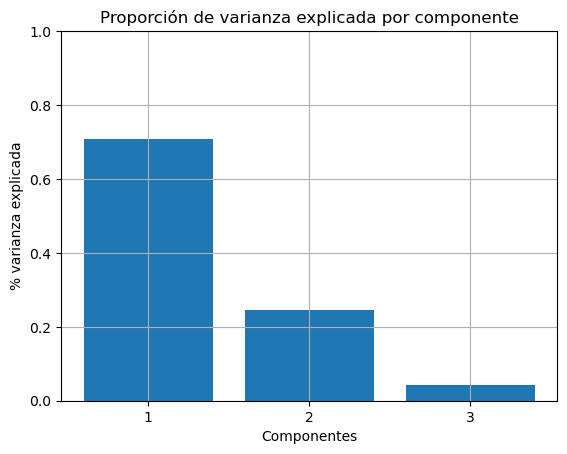

In [126]:
pipeline_iris.summary_reduccion()

# Ahora probamos con el df housing.csv para ver que realmente es general el algoritmo.

In [115]:
df_housing = pd.read_csv('housing.csv')
df_housing = df_housing.loc[(df_housing['median_house_value'] < 500000), :]
df_housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [116]:
pipeline_housing = Pipeline(df_housing)
pipeline_housing.prepararDatos(target='median_house_value', n_cuantiles = 5, n_components=5)
pipeline_housing.df['median_house_value'].dtype

CategoricalDtype(categories=range(0, 5), ordered=True)

In [117]:
pd.DataFrame(pipeline_housing.train_reducido)

,0,1,2,3,4
0,-0.875873,1.756316,-0.168376,0.209482,0.132394
1,-1.668570,2.494629,-0.747676,0.412365,-0.092252
2,-1.133939,1.668596,1.603565,1.191363,0.107149
3,-2.017467,1.511847,-1.373908,0.918390,0.050776
4,-0.008388,0.259736,-0.503733,0.281075,-0.340138
...,...,...,...,...,...
13608,-1.269237,-1.412357,0.097283,0.242200,0.012530
13609,-1.173629,1.435089,0.920479,-0.040795,0.064749
13610,-1.541726,-1.124798,0.926305,1.525439,-0.076564
13611,1.005215,1.533025,1.195647,-1.128807,-0.098025


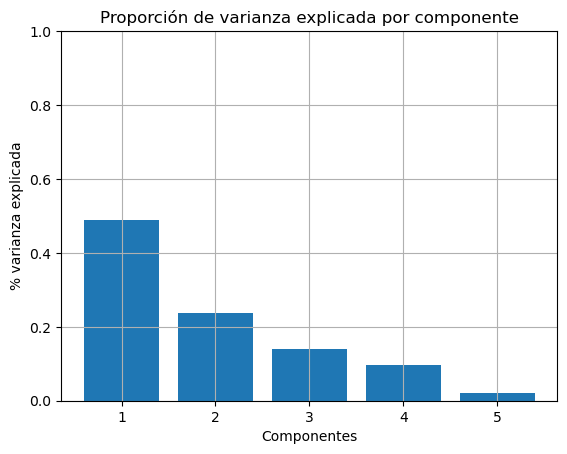

In [118]:
pipeline_housing.summary_reduccion()

# Probando housing con otro modelo de reducción de la dimensionalidad (LDA)

In [121]:
#Con 1 componente principal basta ya que explica más del 90% del dataset

housing_LDA = Pipeline(df_housing)
housing_LDA.prepararDatos(target='median_house_value', n_cuantiles = 5, modelo=LinearDiscriminantAnalysis)
pd.DataFrame(housing_LDA.train_reducido)

,0
0,0.055227
1,2.517222
2,-2.757223
3,0.404194
4,-1.408575
...,...
13608,0.347517
13609,0.405142
13610,-2.094561
13611,-1.364385


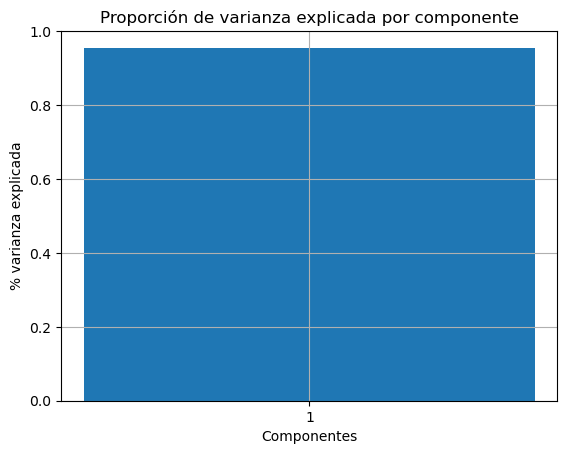

In [122]:
housing_LDA.summary_reduccion()

/tmp/ipykernel_28009/4085529492.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.model.fit(X_train, y_train)


Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



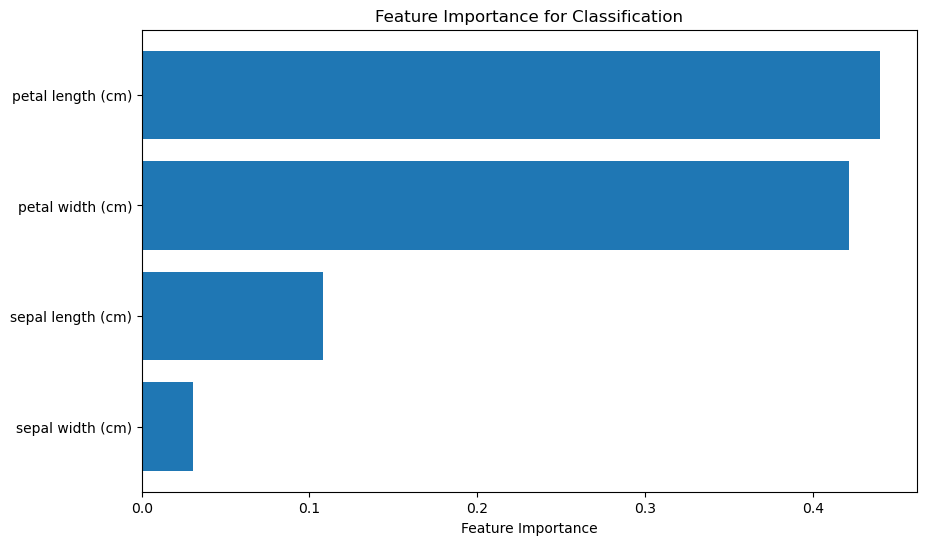

In [89]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

class Pipeline:
    def __init__(self):
        self.model = None

    def load_data(self):
        iris = load_iris()
        X = pd.DataFrame(iris.data, columns=iris.feature_names)
        y = pd.DataFrame(iris.target, columns=['target'])
        return X, y

    def preprocess_data(self, X):
        # En este caso, no necesitamos realizar preprocesamiento específico
        return X

    def train_model(self, X_train, y_train):
        self.model = RandomForestClassifier(n_estimators=100, random_state=42)
        self.model.fit(X_train, y_train)

    def infer(self, X_test):
        return self.model.predict(X_test)

    def present_results(self, y_true, y_pred):
        print("Accuracy:", accuracy_score(y_true, y_pred))
        print("Classification Report:\n", classification_report(y_true, y_pred))

        # Graficar características más importantes si es aplicable
        if hasattr(self.model, 'feature_importances_'):
            feature_importances = self.model.feature_importances_
            features = X.columns
            indices = np.argsort(feature_importances)

            plt.figure(figsize=(10, 6))
            plt.barh(range(len(indices)), feature_importances[indices], align="center")
            plt.yticks(range(len(indices)), [features[i] for i in indices])
            plt.xlabel("Feature Importance")
            plt.title("Feature Importance for Classification")
            plt.show()

# Uso del pipeline
pipeline = Pipeline()

# Cargar datos
X, y = pipeline.load_data()

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocesar datos (en este caso, no hacemos preprocesamiento)
X_train_processed = pipeline.preprocess_data(X_train)
X_test_processed = pipeline.preprocess_data(X_test)

# Entrenar modelo
pipeline.train_model(X_train_processed, y_train)

# Realizar inferencia
y_pred = pipeline.infer(X_test_processed)

# Presentar resultados
pipeline.present_results(y_test, y_pred)
